In [4]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import rustworkx
import rustworkx.visualization
import json

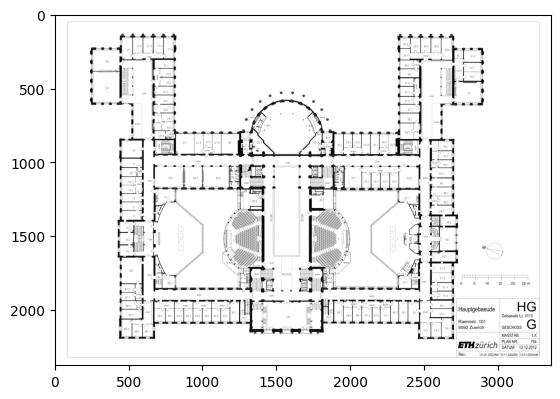

In [5]:
img = cv2.imread('../data/hg_floor_plan_g.png')
plt.imshow(img)

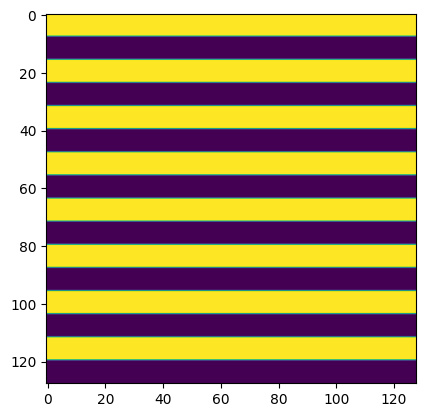

In [6]:
width = 128
height = 128
bar = 8

pattern = np.zeros((height,width))

for i in range(0,width // bar,2):
    pattern[:,i*bar:(i+1)*bar] = 1.0/(width*height)

plt.imshow(pattern.transpose())

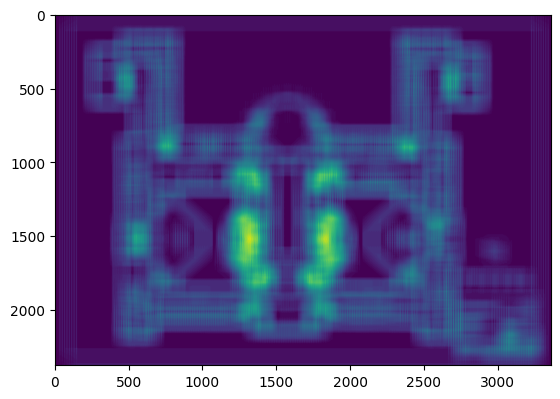

In [7]:
gray = np.copy(img)

edges = cv2.Canny(gray, 50, 150, apertureSize=3)

response = cv2.filter2D(edges, ddepth=1, kernel=pattern)
#response = cv2.

# Display the result
plt.imshow(response)

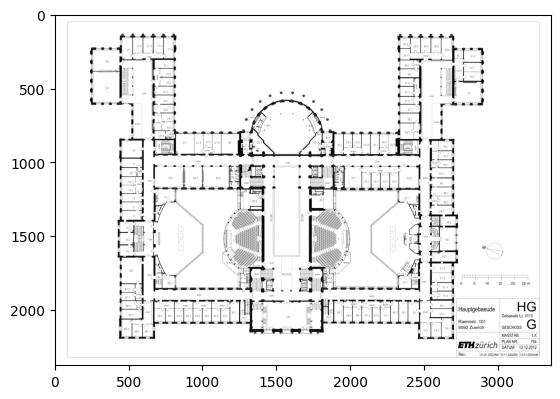

In [8]:
plt.imshow(img)

In [9]:
scale = np.array([img.shape[1], img.shape[0]])

In [10]:
print(scale)

[3361 2376]


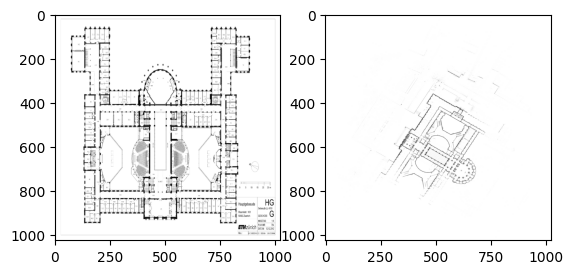

In [11]:
pointcloud_img = cv2.imread("../../localization_server/data/HG_navviz/reference/segmentation/floor_map.png")[::-1,:,:]
(height,width,_) = pointcloud_img.shape
floor_plan = cv2.resize(img, (width, height))

fig, axes = plt.subplots(1,2)
axes[0].imshow(floor_plan)
axes[1].imshow(pointcloud_img)

In [12]:
width,height

(1024, 1024)

In [13]:
colors = []
count = 0

def select(image, k=4):
    global count
    
    selected_points = []
    
    def mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Add clicked point to the list
            selected_points.append((x, y))
            # Display the selected point on the image
            
            if len(selected_points) < len(colors):
                color = colors[len(selected_points)]
            else:
                color = np.random.uniform(255, size=3)
                colors.append(color)
            cv2.circle(image, (x, y), 10, color, -1)
            cv2.imshow(window_name, image)
    
    window_name = 'image_' + str(count)
    cv2.namedWindow(window_name)
    image = np.copy(image)

    # Display the image
    cv2.imshow(window_name, image)

    # Set mouse click event callback
    cv2.setMouseCallback(window_name, mouse_click)

    # Wait for the user to click points and press 'q' to quit
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    # Print selected points
    print("Selected Points:")
    for point in selected_points:
        print(point)
        
    count += 1
    return selected_points

point_cloud_points = select(pointcloud_img)
floor_plan_points = select(floor_plan)

cv2.destroyAllWindows()

Selected Points:
(488, 360)
(458, 404)
(481, 415)
(407, 529)
(393, 520)
(333, 608)
(349, 618)
(271, 729)
(254, 719)
(445, 827)
(535, 700)
(570, 643)
(655, 513)
(587, 688)
Selected Points:
(129, 946)
(207, 949)
(208, 900)
(402, 902)
(402, 927)
(551, 929)
(551, 903)
(750, 903)
(750, 943)
(755, 512)
(527, 510)
(428, 507)
(204, 505)
(473, 426)


In [14]:
(len(floor_plan_points), len(point_cloud_points))

(14, 14)

In [15]:
np.array([0,1,2,3,4,5]).reshape((2,3))

array([[0, 1, 2],
       [3, 4, 5]])

In [16]:
def compute_linear_transformation(source_points, destination_points):
    A = np.zeros((2 * len(source_points), 6))
    b = np.zeros(2 * len(source_points))
    
    for i in range(len(source_points)):
        x_s, y_s = source_points[i]
        x_d, y_d = destination_points[i]
        A[2*i] = [x_s,y_s,1,0,0,0]
        A[2*i+1] = [0,0,0,x_s,y_s,1]
        b[2*i] = x_d
        b[2*i+1] = y_d

    # Solving the linear system using SVD
    transformation_matrix = np.linalg.lstsq(A,b)[0]
    transformation_matrix = np.concatenate([transformation_matrix,[0,0,1]]).reshape((3,3))
    return transformation_matrix

In [17]:
print((height,width))

floor_to_rel = compute_linear_transformation(np.array(floor_plan_points)/[width,height],
                              np.array(point_cloud_points)/[width,height])

aabb_min = np.array([
    -148.161,
    -89.9408,
    -9.21643
])
aabb_max = np.array([
    111.123,
    189.154,
    58.9182
])

rel_to_abs = np.array([
    [aabb_max[0]-aabb_min[0], 0,                        aabb_min[0]],
    [0                      ,  -(aabb_max[1]-aabb_min[1]), aabb_max[1]], # y-flipped, since in image up is 0
    [0,0,1]
])

print("floor_to_relative = ", floor_to_rel)
print("relative_to_absolute =", rel_to_abs)


json.dumps({
    "floor_to_relative": floor_to_rel.tolist(),
    "relative_to_absolute": rel_to_abs.tolist()
})

(1024, 1024)
floor_to_relative =  [[-0.37980244 -0.44468991  0.93600452]
 [ 0.57775964 -0.2493158   0.50885002]
 [ 0.          0.          1.        ]]
relative_to_absolute = [[ 259.284     0.     -148.161 ]
 [   0.     -279.0948  189.154 ]
 [   0.        0.        1.    ]]


/var/folders/3d/9nhm2px925gfpntwdmfgxjkc0000gn/T/ipykernel_89848/4277589055.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformation_matrix = np.linalg.lstsq(A,b)[0]


'{"floor_to_relative": [[-0.37980244230776083, -0.4446899053418908, 0.9360045227534673], [0.5777596438092669, -0.24931580397943037, 0.5088500153185898], [0.0, 0.0, 1.0]], "relative_to_absolute": [[259.284, 0.0, -148.161], [0.0, -279.09479999999996, 189.154], [0.0, 0.0, 1.0]]}'

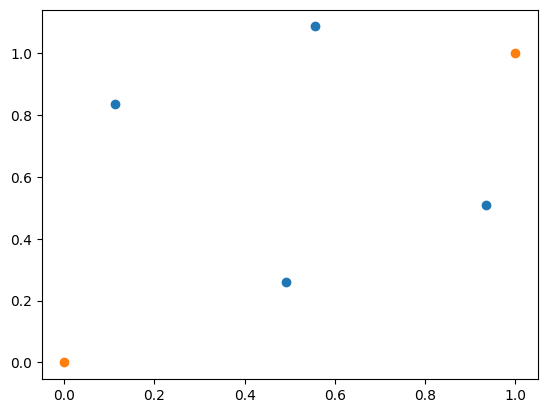

In [18]:
x00 = floor_to_rel @ np.array([0,0,1])
x01 = floor_to_rel @ np.array([0,1,1])
x10 = floor_to_rel @ np.array([1,0,1])
x11 = floor_to_rel @ np.array([1,1,1])

x = np.stack([x00,x01,x10,x11])
x1 = np.array([[0,0,1], [1,1,1]])

plt.scatter(x[:,0], x[:,1])
plt.scatter(x1[:,0], x1[:,1])

/var/folders/3d/9nhm2px925gfpntwdmfgxjkc0000gn/T/ipykernel_89848/4277589055.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformation_matrix = np.linalg.lstsq(A,b)[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


uint8
(3, 3)
[[-7.08978352e-01  1.26457591e+00  2.06616226e+01]
 [-1.64265573e+00 -1.07987363e+00  2.13735494e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
(3, 3)


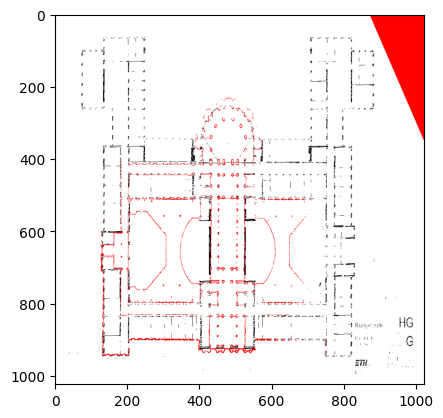

In [19]:
warp_matrix = compute_linear_transformation(np.array(point_cloud_points), np.array(floor_plan_points))
#compute_linear_transformation(np.array(point_cloud_points), np.array(floor_plan_points))
print(floor_plan.dtype)
#floor_plan = floor_plan.astype(np.float32)
print(warp_matrix.shape)
print(warp_matrix)
#print(pointcloud_img.dtype)
print(warp_matrix.shape)


pointcloud_warped = cv2.warpAffine(pointcloud_img.astype(np.float32), warp_matrix[:2,:], (floor_plan.shape[1], floor_plan.shape[0]))
_,mask = cv2.threshold(pointcloud_warped, 100, 255, cv2.THRESH_BINARY_INV)

red = np.zeros((height,width,3))
red[:,:,0] = 255 

composite = np.choose(mask==255, [floor_plan, red])
plt.imshow(composite)

In [20]:
xs = []

floor_to_relative

NameError: name 'floor_to_relative' is not defined

In [ ]:
# Rustworkx's undirected graph type.
graph = rustworkx.PyGraph()

def apply_trans(matrix, pos):
    pos = np.array(pos)
    return (matrix @ [pos[0],pos[1],1])[:2]

rel_to_world = lambda x: apply_trans(rel_to_abs @ floor_to_rel, x)
world_to_rel = lambda x: apply_trans(np.linalg.inv(rel_to_abs @ floor_to_rel), x)

# Each time add node is called, it returns a new node index
a = graph.add_node({"label": "A", "pos": rel_to_world([0.5,0.3])})
b = graph.add_node({"label": "B", "pos": rel_to_world([0.5,0.5])})
c = graph.add_node({"label": "C", "pos": rel_to_world([0.15,0.5])})
d = graph.add_node({"label": "D", "pos": rel_to_world([0.85,0.5])})

# add_edges_from takes tuples of node indices and weights,
# and returns edge indices
graph.add_edges_from([(a, b, {"length": np.linalg.norm(graph[a]["pos"] - graph[b]["pos"])}), 
                      (b, c, {"length": np.linalg.norm(graph[b]["pos"] - graph[c]["pos"])}),
                       (b, d, {"length": np.linalg.norm(graph[b]["pos"] - graph[d]["pos"])})])

paths = rustworkx.all_pairs_dijkstra_shortest_paths(graph, edge_cost_fn= lambda x: x["length"])
list(paths[c][d])

In [ ]:
rel_to_abs @ [1,1,1]

In [ ]:
plt.imshow(img)
rustworkx.visualization.mpl_draw(graph, pos={i: world_to_rel(data["pos"])*scale for i,data in enumerate(graph.nodes())})

In [ ]:
def graph_to_json(graph):
    nodes = {}
    for node, data in enumerate(graph.nodes()):
        nodes[node] = {
            "label": data["label"],
            "pos": {"x": data["pos"][0], "y": data["pos"][1]}
        }
    edges = {}
    for edge, data in enumerate(graph.edges()):
        u,v = graph.get_edge_endpoints_by_index(edge)
        edges[edge] = {
            "u": u,
            "v": v, 
            "data": {"length": data["length"]}
        }

        
    print(list(graph.edge_indices()))
    return json.dumps({"nodes": nodes, "edges": edges})
    
j = graph_to_json(graph)
j

In [ ]:
def graph_from_json(json):
    idx_to_node = {}
    graph = rustworkx.PyGraph()
    for id,data in sorted(json["nodes"].items(), key=lambda x: x[0]):
        idx_to_node[int(id)] = graph.add_node({
            "label": data["label"],
            "pos": np.array([data["pos"]["x"], data["pos"]["y"]])
        })
        
    print(idx_to_node)
        
    for id,data in sorted(json["edges"].items(), key=lambda x: x[0]):
        graph.add_edge(idx_to_node[data["u"]],idx_to_node[data["v"]],{"length": data["length"]})
    
    return graph

graph2 = graph_from_json(json.loads(j))
plt.imshow(img)
rustworkx.visualization.mpl_draw(graph2, pos={i: data["pos"]*scale for i,data in enumerate(graph.nodes())})

In [ ]:
{
    "_to_floorplan:"
}